# Load libraries

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier

# Read train and test data

In [88]:
dfXtrain = pd.read_csv('X.train.csv')
dfXtest = pd.read_csv('X.test.csv')
dfYtrain = pd.read_csv('y.train.csv')
Xtrain = np.array(dfXtrain)
Xtest = np.array(dfXtest)

ytrain = np.array(dfYtrain['label'])

In [89]:
print('Data size:', dfXtrain.shape)
dfXtrain.head()

Data size: (4099, 1330)


,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V1322,V1323,V1324,V1325,V1326,V1327,V1328,V1329,V1330,V1331
0,826.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,0.0,0.5
1,15.0,0.0,0,0.0,0.0,0.0,0.0,0.030303,0.083333,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0
2,242.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,1.0,1.0,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.5
3,1038.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
4,971.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


# Replace all NaN's in train and test data to most frequent values in train data

In [90]:
Xbig = np.vstack((Xtrain, Xtest))

In [91]:
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
imp.fit(Xbig)

Xtrain = imp.transform(Xtrain)
Xtest = imp.transform(Xtest)

# Train Random Forest classifier

In [29]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xtrain, ytrain, test_size=0.5)

In [21]:
from sklearn.metrics import log_loss

In [22]:
def get_score_list(X, y, clf):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        predictions.append(tree.predict(X))
        rf_prediction = mean(predictions, axis=0)
        score.append(log_loss(y, rf_prediction))
        if i % 100 == 0:
            print(score[-1])
    return score

In [23]:
def plot_score_graph(clf, X_train, X_test, y_train, y_test, prefix, print_train=True):
    clf.fit(X_train, y_train)
    train_score = get_score_list(X_train, y_train, clf)
    test_score = get_score_list(X_test, y_test, clf)
    if print_train:
        plot(train_score, label=prefix + ' train set error')
    plot(test_score, label=prefix + ' test set error')
    xlabel('n_estimators')
    ylabel('LL')
    legend()

1.44966576606
0.0565126604105
0.0562381129351
0.0560458896904
0.0562365567473
0.0560116177093
0.0558022176273
0.0558690050973
0.0557498531093
0.0557062326575
4.41428222219
0.270963045879
0.227277755994
0.227594269352
0.228135653814
0.226620680053
0.212933848406
0.212756636964
0.212621415146
0.21259157086


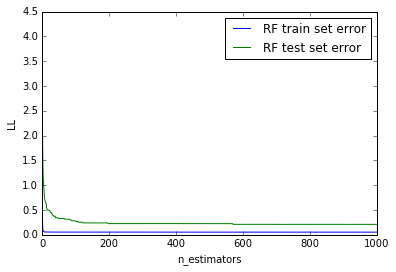

In [30]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=330, n_jobs=-1),
               X_train[:, :330], X_test[:, :330], y_train, y_test,
               prefix='RF')

In [25]:
from sklearn.grid_search import GridSearchCV

In [31]:
clf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_features=330, n_jobs=-1)
clf.fit(Xtrain[:, :330], ytrain)

ypred = clf.predict_proba(Xtest[:, :330])[:, 1]

Попробуем разобраться с генетической информацией

In [92]:
meta = pd.read_csv('MetaData.csv')
print('Meta size:', meta.shape)
meta.head()

Meta size: (1330, 3)


,varnum,type,Column Type
0,V2,char,Numeric
1,V3,num,Category
2,V4,num,Category
3,V5,num,Category
4,V6,num,Category


In [93]:
dfX_train = pd.DataFrame(data=Xtrain)
dfX_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329
0,826.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,0.055556,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.5
1,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.083333,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0
2,242.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,0.055556,0.0,...,1.0,1.0,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.5
3,1038.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,0.055556,0.0,...,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
4,971.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,0.055556,0.0,...,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


In [104]:
categorial = dfX_train.columns[meta.ix[:330-1]['Column Type'] == 'Category']
categorial

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            220, 221, 222, 223, 224, 225, 226, 305, 327, 328],
           dtype='int64', length=181)

In [105]:
X_big_encoded = pd.get_dummies(pd.DataFrame(data=np.vstack((Xtrain, Xtest))), columns=categorial)

X_train_encoded = X_big_encoded[:4099]
print(X_train_encoded.shape)
X_test_encoded = X_big_encoded[4099:]
print(X_test_encoded.shape)

(4099, 1651)
(1366, 1651)


In [106]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_train_encoded, ytrain, test_size=0.5)

1.92165099448
0.0565816901237
0.0559838520617
0.0557184120603
0.0553479990526
0.0554501947552
0.055539005136
0.0554456180817
0.0554752021226
0.0553850180213
3.74033420538
0.210156419854
0.20888004161
0.20670673366
0.206610937259
0.206112681515
0.206431371153
0.206596233353
0.20724991688
0.207085323168


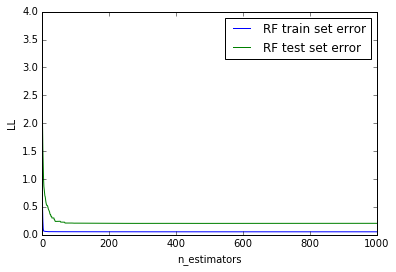

In [111]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=500, n_jobs=-1),
               X_train, X_test, y_train, y_test,
               prefix='RF')

In [112]:
clf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_features=500, n_jobs=-1)
clf.fit(X_train_encoded, ytrain)

ypred = clf.predict_proba(X_test_encoded)[:, 1]

# Save predictions

In [113]:
dfpred = pd.DataFrame()
dfpred['Id'] = np.arange(len(ypred))
dfpred['Prediction'] = ypred

dfpred.to_csv('y.predicted.csv', index = False)